In [1]:
Pkg.add("LibExpat"); using LibExpat
run(`apt-get install tcl8.5`)
Pkg.add("Winston"); using Winston

Pkg.add("MXNet");
ENV["MXNET_HOME"] = "/mxnet"
Pkg.add("GraphPlot"); 

INFO: Package LibExpat is already installed
INFO: METADATA is out-of-date — you may not have the latest version of LibExpat
INFO: Use `Pkg.update()` to get the latest versions of your packages


Reading package lists...
Building dependency tree...
Reading state information...
tcl8.5 is already the newest version (8.5.19-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


INFO: Package Winston is already installed
INFO: METADATA is out-of-date — you may not have the latest version of Winston
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Package MXNet is already installed
INFO: METADATA is out-of-date — you may not have the latest version of MXNet
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [25]:
using MXNet
using GraphPlot

In [26]:
using LightGraphs
import LightGraphs.SimpleGraphs: SimpleEdge, SimpleDiGraph
include("CreateOSMGraphs.jl")
using CreateOSMGraphs


Use "const Styles = @compat Union{Style,Dict{Int,Style}}" instead.


In [27]:
@time graph, vprops, eprops, edgeDict, 
nodesLLA, highways, geohash2edgedict = CreateOSMGraphs.CreateOSMGraph("map.osm");

getOSMData
  1.205218 seconds (8.83 M allocations: 400.116 MiB, 10.57% gc time)
intersections
  0.000402 seconds (2.50 k allocations: 263.438 KiB)
roadways
  0.009889 seconds (2.07 k allocations: 132.376 KiB)
segmentHighways
  0.231908 seconds (99.52 k allocations: 4.869 MiB, 2.74% gc time)
createGraph
  0.164797 seconds (204.39 k allocations: 8.307 MiB)
  3.071577 seconds (9.94 M allocations: 456.355 MiB, 4.99% gc time)


In [28]:
graphNodeId2MapNodeId = Dict()

locs_x = Array{Float64, 1}(nv(graph))
locs_y = Array{Float64, 1}(nv(graph))

for (k, v) in sort(vprops, by=x -> vprops[x])
    graphNodeId2MapNodeId[v] = k
    println(nodesLLA[k].coords.lat, ",", nodesLLA[k].coords.lon)
    
    locs_x[v] = nodesLLA[k].coords.lon
    locs_y[v] = -nodesLLA[k].coords.lat
end

59.4048649,17.9408975
59.4057929,17.942022
59.4021367,17.9709812
59.4023485,17.9523533
59.3966408,17.9377121
59.4064887,17.9450009
59.4009979,17.9413432
59.4090091,17.9747309
59.4035925,17.9538342
59.4046285,17.9477561
59.4067087,17.939507
59.4103517,17.9725788
59.4048035,17.9428344
59.3970355,17.9440695
59.4049581,17.9426232
59.4083447,17.9659768
59.40217,17.9467437
59.4061973,17.952379
59.4029988,17.949933
59.4088542,17.9220406
59.4091545,17.957725
59.4016303,17.9452049
59.4075072,17.9429575
59.4014547,17.9712111
59.4029809,17.9546129
59.4050599,17.9428575
59.4055107,17.9269184
59.40213,17.9711586
59.4074026,17.9378328
59.399151,17.9574592
59.4211459,17.9549391
59.3970601,17.953012
59.4089453,17.9460193
59.4038729,17.945633
59.4026809,17.973279
59.4070218,17.9447831
59.4061222,17.9310689
59.4022743,17.9524516
59.4079813,17.9586985
59.4126461,17.9328149
59.4055248,17.9424466
59.4096878,17.9237798
59.4093142,17.9722786
59.4022958,17.9633678
59.4058979,17.9275358
59.407488,17.9376889
59

In [29]:
num_nodes = nv(graph)
max_out_degree = maximum(outdegree(graph))

# generate distance matrix
g_distmx = fill(Inf, (num_nodes, num_nodes))

for (edge, info_dict) in edgeDict
    g_distmx[edge.src, edge.dst] = info_dict[:weight]
end

# calculate between centrality
node_centrality = betweenness_centrality(graph)

# normalize x y coordinates
x_min, x_max = minimum(locs_x), maximum(locs_x)
norm_locs_x = map(c -> (c - x_min) / (x_max - x_min), locs_x)

y_min, y_max = minimum(locs_y), maximum(locs_y)
norm_locs_y = map(c -> (c - y_min) / (y_max - y_min), locs_y)

361-element Array{Float64,1}:
 0.600108
 0.565903
 0.700668
 0.692861
 0.903244
 0.540256
 0.742644
 0.447356
 0.647008
 0.608822
 0.532147
 0.397868
 0.602372
 ⋮       
 0.457768
 0.463585
 0.476062
 0.408237
 0.819886
 0.653757
 0.732327
 0.804306
 0.818711
 0.584978
 0.838394
 0.388229

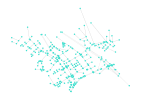

In [30]:
gplot(graph, norm_locs_x, norm_locs_y, arrowlengthfrac=0.0)

In [164]:
function generate_stochastic_dataset(G, sample_size_lower_bound=100, verbose_frequent=10)
    
    pair_path_dict = Dict()
    sample_cnt = 0
    X = []
    y = []
    
    while true
        src = rand(1:num_nodes)
        dst = rand(1:num_nodes)
        
        src == dst && continue
        
        for (src, dst) in [(src, dst), (dst, src)]
    
            path = a_star(graph, src, dst, g_distmx)
            
            length(path) == 0 && break
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = 0
            cur_node = src
            
            for edge in path
                
#                 println("parent:($(parent_node)), X:($(cur_node), $(dst)), y:($(edge.dst))")
                
                
                push!(X, encode_edges(G, parent_node, cur_node, src, dst))
                push!(y, edge.dst)
                
                parent_node = cur_node
                cur_node = edge.dst
                
                sample_cnt += 1
                sample_cnt % verbose_frequent == 0 && println("Collected $(sample_cnt) samples.")
            end
        end
        
        sample_cnt >= sample_size_lower_bound && break
        
    end
    
    return X, y, pair_path_dict, sample_cnt
    
end

generate_stochastic_dataset (generic function with 3 methods)

In [165]:
function encode_edges(G, parent, node, src, dst)
    
    ret = fill(0.0, (max_out_degree, 7))
    
    for (idx, out_neighbor) in enumerate(outneighbors(G, node))
        
        out_neighbor == parent && continue
        
        ret[idx, 1] = node_centrality[out_neighbor]        
        ret[idx, 2] = g_distmx[node, out_neighbor]
        ret[idx, 3] = 0.0
        ret[idx, 4] = 0.0
        ret[idx, 5] = 0.0
        ret[idx, 6] = 0.0
        
        ret[idx, end] = out_neighbor
        
    end
    
    return ret
    
end

encode_edges (generic function with 1 method)

In [166]:
features, labels, pair_path_dict, sample_cnt = generate_stochastic_dataset(graph);

Collected 10 samples.
Collected 20 samples.
Collected 30 samples.
Collected 40 samples.
Collected 50 samples.
Collected 60 samples.
Collected 70 samples.
Collected 80 samples.
Collected 90 samples.
Collected 100 samples.
Collected 110 samples.
Collected 120 samples.
Collected 130 samples.
Collected 140 samples.
Collected 150 samples.
Collected 160 samples.


In [168]:
features[1][1, end]

159.0